In [55]:
import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
from unittest import TestCase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Set up data:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

# Initialise project:
project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view()

# Extra data specific to ODME:
index = car_graph.nodes_to_indices
dims = matrix.matrix_view.shape
count_vol_cols = ["class", "link_id", "direction", "obs_volume"]
# Still need to add mode/class name to these!!!

# Initial assignment parameters:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5
assignment.set_algorithm("msa")

In [58]:
algorithm = "reg_spiess"

# Get original flows:
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
# SQUISH EXTRA DIMENSION FOR NOW - DEAL WITH THIS PROPERLY LATER ON!!!
matrix.matrix_view = np.squeeze(matrix.matrix_view, axis=2)

# Set the observed count volumes:
flow = lambda i: assign_df.loc[assign_df["link_id"] == i, "matrix_ab"].values[0]
count_volumes = pd.DataFrame(
    data=[["car", i, 1, flow(i)] for i in assign_df["link_id"]],
    columns=count_vol_cols
)

# Store original matrix
original_demand = np.copy(matrix.matrix_view)

# Perturb original matrix:
np.random.seed(0)
perturbation = 5 # %
perturbation_matrix = np.random.uniform(1 - perturbation/100, 1 + perturbation/100, size=dims)
new_matrix = np.round(matrix.matrix_view * perturbation_matrix)

In [59]:
all_odme = []

for i in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    # Perform ODME:
    all_odme.append(ODME(assignment,
        count_volumes,
        stop_crit=(10, 250, 1000, 50),
        alpha=i/10,
        algorithm=algorithm)
    )
    all_odme[i-1].execute()
    print(f"{i} has finished running.")
cumulative_factors = [odme.get_cumulative_factors() for odme in all_odme]

1 has finished running.
2 has finished running.
3 has finished running.
4 has finished running.
5 has finished running.
6 has finished running.
7 has finished running.
8 has finished running.
9 has finished running.
10 has finished running.


In [60]:
for i in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    # Perform ODME:
    odme = ODME(assignment,
        count_volumes,
        stop_crit=(10, 250, 1000, 50),
        alpha=i/10,
        algorithm=algorithm)
    print(f"{i/10} alpha -> {odme.estimate_alpha(i/10)}")

0.1 alpha -> 0.08442878451502234
0.2 alpha -> 0.14610694221866458
0.3 alpha -> 0.19313836999338124
0.4 alpha -> 0.23018658878731332
0.5 alpha -> 0.2601252621648833
0.6 alpha -> 0.2848217021451337
0.7 alpha -> 0.3055419339816503
0.8 alpha -> 0.32317468737343513
0.9 alpha -> 0.33836220106047776
1.0 alpha -> 0.35158013764061374


In [61]:
cumulative_stats = [data.describe() for data in cumulative_factors]

In [62]:
all_stats = pd.concat(cumulative_stats, axis=1)
all_stats = all_stats.transpose().reset_index(drop=True)
all_stats["alpha"] = (all_stats.index + 1) / 10
all_stats

,count,mean,std,min,25%,50%,75%,max,alpha
0,576.0,1.169061,2.292599,6.908439e-06,0.209229,0.761480,1.390376,42.441316,0.1
1,576.0,1.057371,1.466896,3.076861e-07,0.110613,0.693261,1.314633,17.289554,0.2
2,576.0,1.166273,2.556551,4.024299e-05,0.097138,0.500969,1.031250,28.925359,0.3
3,576.0,1.062291,1.673183,2.290448e-05,0.139321,0.633470,1.224381,20.112607,0.4
4,576.0,1.100089,1.287691,1.033637e-04,0.338889,0.784229,1.345127,10.315256,0.5
5,576.0,1.087731,1.107154,7.745949e-03,0.399937,0.934332,1.357268,11.607419,0.6
6,576.0,1.091555,1.227448,3.459704e-03,0.363346,0.849410,1.314648,10.159990,0.7
7,576.0,1.080951,1.493339,1.125295e-05,0.250065,0.700667,1.236231,14.664514,0.8
8,576.0,1.110860,1.851922,5.716766e-05,0.223632,0.764361,1.288041,27.094659,0.9
9,576.0,1.042180,1.376246,5.435358e-04,0.287134,0.703673,1.245586,20.802761,1.0


<Axes: xlabel='alpha', ylabel='mean'>

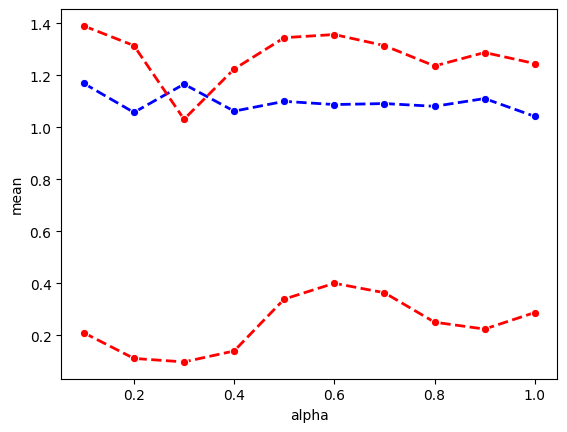

In [63]:
sns.lineplot(x='alpha', y='mean', data=all_stats, marker='o', color='blue', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='75%', data=all_stats, marker='o', color='red', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='25%', data=all_stats, marker='o', color='red', linestyle='--', linewidth=2)

<Axes: xlabel='alpha', ylabel='std'>

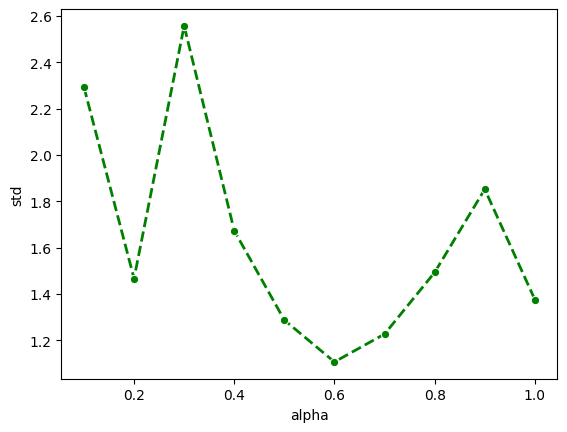

In [64]:
sns.lineplot(x='alpha', y='std', data=all_stats, marker='o', color='green', linestyle='--', linewidth=2)

In [65]:
print(cumulative_stats[2])
print(cumulative_stats[5])
print(cumulative_stats[8])

          Factors
count  576.000000
mean     1.166273
std      2.556551
min      0.000040
25%      0.097138
50%      0.500969
75%      1.031250
max     28.925359
          Factors
count  576.000000
mean     1.087731
std      1.107154
min      0.007746
25%      0.399937
50%      0.934332
75%      1.357268
max     11.607419
          Factors
count  576.000000
mean     1.110860
std      1.851922
min      0.000057
25%      0.223632
50%      0.764361
75%      1.288041
max     27.094659


In [66]:
matrix.matrix_view = np.copy(new_matrix)

# Perform ODME:
odme = ODME(assignment,
    count_volumes,
    stop_crit=(10, 250, 1000, 50),
    alpha=i/10,
    algorithm="spiess")
odme.execute()
spiess_cumulative = odme.get_cumulative_factors()

In [67]:
spiess_cumulative.describe()

,Factors
count,576.000000
mean,1.042180
std,1.376246
min,0.000544
25%,0.287134
50%,0.703673
75%,1.245586
max,20.802761


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


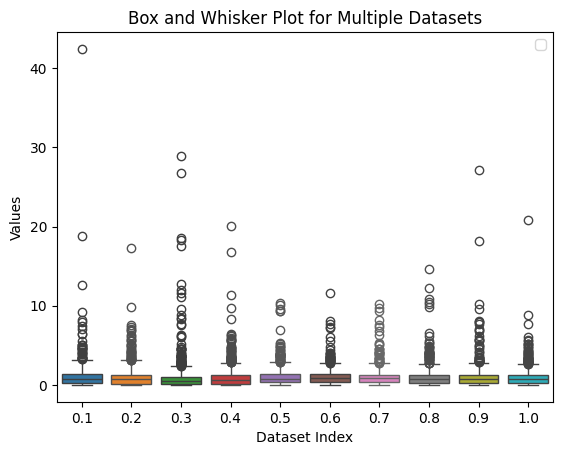

In [68]:
# Create a figure and axis
fig, ax = plt.subplots()

# Loop through each DataFrame in the list
for i, df in enumerate(cumulative_factors):
    # Plot the box and whisker plot for the current DataFrame
    sns.boxplot(x=(i+1)/10, y='Factors', data=df, ax=ax)

# Set labels and title
ax.set_xlabel('Dataset Index')
ax.set_ylabel('Values')
ax.set_title('Box and Whisker Plot for Multiple Datasets')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [69]:
statistics = [odme.get_all_statistics() for odme in all_odme]

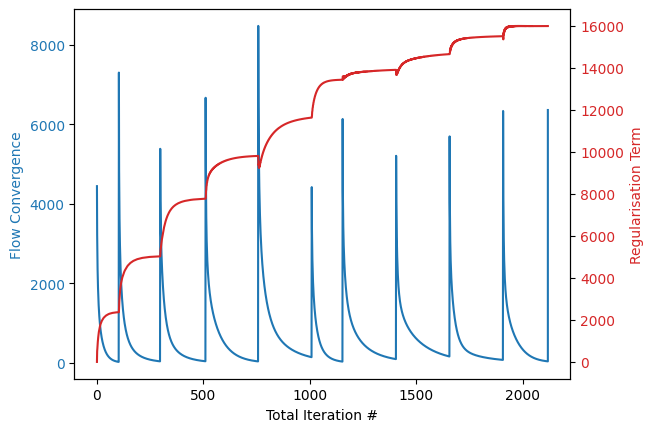

In [71]:
stats_spiess = statistics[9]
# Plot the first set of data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Total Iteration #')
ax1.set_ylabel('Flow Convergence', color=color)
ax1.plot(stats_spiess["Total Iteration #"], stats_spiess["Flow Objective"].apply(lambda x: x**0.5), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Regularisation Term', color=color)
ax2.plot(stats_spiess["Total Iteration #"], stats_spiess["Reg Objective"].apply(lambda x: x**0.5), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.show()

<Axes: xlabel='Total Iteration #', ylabel='Convergence'>

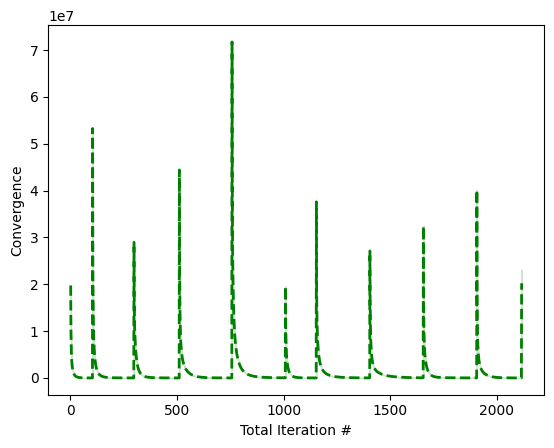

In [85]:
sns.lineplot(x='Total Iteration #', y='Convergence', data=stats_spiess, color='green', linestyle='--', linewidth=2)

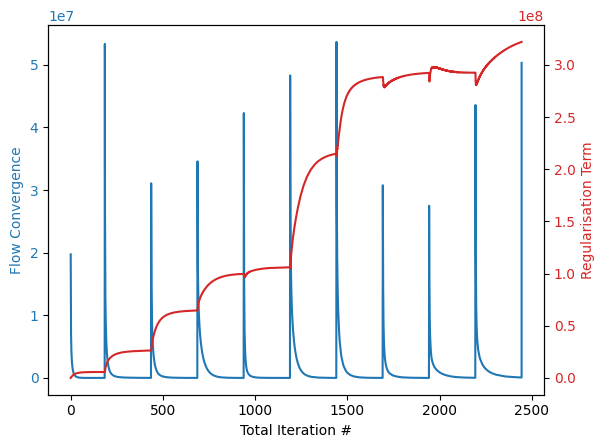

In [81]:
stats_regsp = statistics[0]
# Plot the first set of data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Total Iteration #')
ax1.set_ylabel('Flow Convergence', color=color)
#ax1.plot(stats_regsp["Total Iteration #"], stats_regsp["Flow Objective"].apply(lambda x: x**0.5), color=color)
ax1.plot(stats_regsp["Total Iteration #"], stats_regsp["Flow Objective"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Regularisation Term', color=color)
#ax2.plot(stats_regsp["Total Iteration #"], stats_regsp["Reg Objective"].apply(lambda x: x**0.5), color=color)
ax2.plot(stats_regsp["Total Iteration #"], stats_regsp["Reg Objective"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.show()

<Axes: xlabel='Total Iteration #', ylabel='Convergence'>

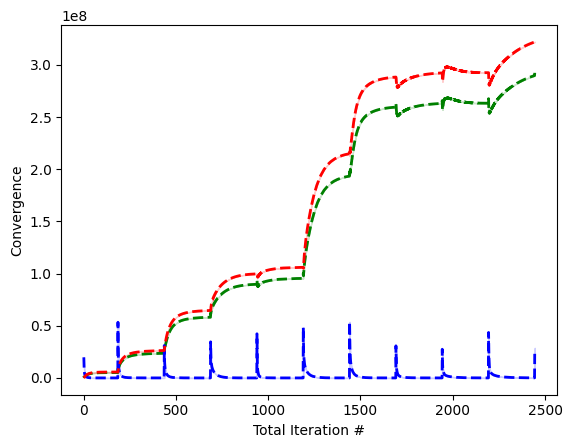

In [84]:
sns.lineplot(x='Total Iteration #', y='Convergence', data=stats_regsp, color='green', linestyle='--', linewidth=2)
sns.lineplot(x='Total Iteration #', y='Flow Objective', data=stats_regsp, color='blue', linestyle='--', linewidth=2)
sns.lineplot(x='Total Iteration #', y='Reg Objective', data=stats_regsp, color='red', linestyle='--', linewidth=2)